In [329]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [330]:
store_orders = pd.read_csv("verizon_takehome.csv")
store_orders.head(3)

,Customer_ID,Called_within_1_day,Age,Bill_amount,used_app_before,used_website_before,Income,#_of_calls_in_the_past,Avg_Sentiment_past_Calls
0,0.999,1,53.000,15,0,0,"$433,342",8,-20.000
1,0.304,1,77.000,13,0,0,"$115,520",9,-10.000
2,0.289,1,79.000,8,0,0,"$191,138",9,-16.000


## Clean Data

In [342]:
# Outlier in Bill_amount of 10,0000,0000 - remove it
store_orders = store_orders[store_orders['Bill_amount'] < 1000000.000] 

# remove dollar sign from Income column
store_orders['Income'] = store_orders['Income'].replace({'\$':'', ',': ''}, regex = True).astype('int64')

In [332]:
average_ages = store_orders.groupby('Called_within_1_day').mean()
average_ages

,Customer_ID,Age,Bill_amount,used_app_before,used_website_before,#_of_calls_in_the_past,Avg_Sentiment_past_Calls
Called_within_1_day,,,,,,,
0,0.490,22.641,10.739,0.872,0.821,3.489,2.809
1,0.496,65.430,10.980,0.080,0.602,10.667,-7.458


In [333]:
# impute missing age values using the average for each called / not called

def impute_age(order_row):
    if pd.isnull(order_row['Age']):
        if order_row['Called_within_1_day'] == 1:
            return average_ages['Age'][1]
        else:
            return average_ages['Age'][0]
    else:
        return order_row['Age']
        
store_orders['Age'] = store_orders.apply(impute_age, axis=1)

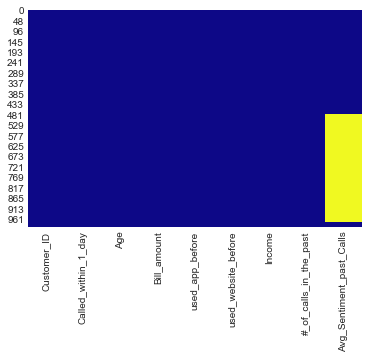

In [334]:
# null values
sns.heatmap(store_orders.isnull(),cbar=False, cmap="plasma")

## Exploratory analysis

In [335]:
store_orders.drop('Customer_ID', axis=1).describe()

,Called_within_1_day,Age,Bill_amount,used_app_before,used_website_before,#_of_calls_in_the_past,Avg_Sentiment_past_Calls
count,999.000,999.000,999.000,999.000,999.000,999.000,505.000
mean,0.249,33.306,10.799,0.675,0.767,5.278,-2.253
std,0.433,19.425,5.928,0.469,0.423,6.782,8.478
min,0.000,15.000,1.000,0.000,0.000,0.000,-20.000
25%,0.000,20.000,6.000,0.000,1.000,0.000,-9.000
50%,0.000,25.000,11.000,1.000,1.000,1.000,1.000
75%,0.000,30.000,16.000,1.000,1.000,11.000,5.000
max,1.000,80.000,20.000,1.000,1.000,20.000,10.000


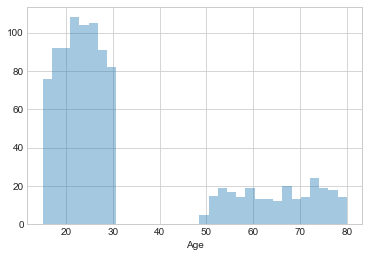

In [336]:
sns.set_style('whitegrid')
sns.distplot(store_orders['Age'].dropna(), kde=False)

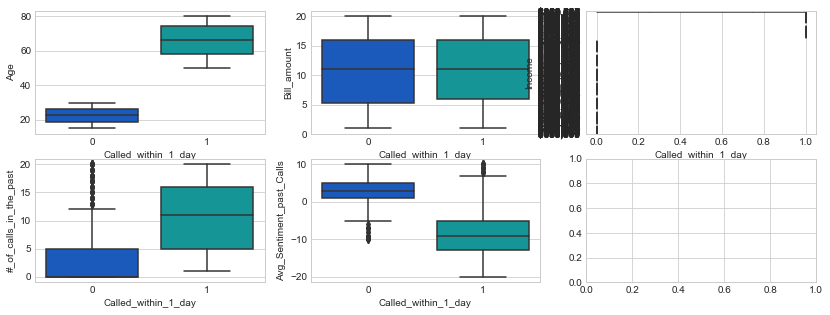

In [337]:
fig, ax = plt.subplots(2,3, figsize=(14,5))
sns.boxplot(x='Called_within_1_day',y='Age',data=store_orders,palette='winter', ax=ax[0,0])
sns.boxplot(x='Called_within_1_day',y='Bill_amount',data=store_orders,palette='winter', ax=ax[0,1])
sns.boxplot(x='Called_within_1_day',y='Income',data=store_orders,palette='winter', ax=ax[0,2])
sns.boxplot(x='Called_within_1_day',y='#_of_calls_in_the_past',data=store_orders,palette='winter', ax=ax[1,0])
sns.boxplot(x='Called_within_1_day',y='Avg_Sentiment_past_Calls',data=store_orders,palette='winter', ax=ax[1,1])

# Large difference in Age - likely good indicator of if they will call 
# Significant differnce in #_of_calls_in_the_past and Avg_Sentiment_past_Calls
# Little difference in Bill_amount, Income - likely poor indicator of i they will call 

In [338]:
store_orders_corr = store_orders[['Called_within_1_day','Age','Bill_amount','Avg_Sentiment_past_Calls',
                                  '#_of_calls_in_the_past','used_app_before','Income','used_website_before']]
store_orders_corr.corr()

,Called_within_1_day,Age,Bill_amount,Avg_Sentiment_past_Calls,#_of_calls_in_the_past,used_app_before,used_website_before
Called_within_1_day,1.000,0.953,0.018,-0.606,0.458,-0.731,-0.224
Age,0.953,1.000,0.019,-0.572,0.436,-0.694,-0.210
Bill_amount,0.018,0.019,1.000,-0.035,0.035,-0.020,0.002
Avg_Sentiment_past_Calls,-0.606,-0.572,-0.035,1.000,0.035,0.531,0.569
#_of_calls_in_the_past,0.458,0.436,0.035,0.035,1.000,-0.233,0.056
used_app_before,-0.731,-0.694,-0.020,0.531,-0.233,1.000,0.602
used_website_before,-0.224,-0.210,0.002,0.569,0.056,0.602,1.000


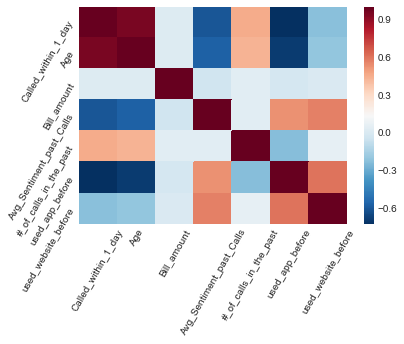

In [339]:
ax_sns = sns.heatmap(store_orders_corr.corr(), cmap='RdBu_r');
ax_sns.set_xticklabels(ax_sns.get_xticklabels(),rotation=60);
ax_sns.set_yticklabels(ax_sns.get_yticklabels(),rotation=60);

## Feature selection

In [340]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

In [343]:
X_orig = store_orders[['Age','Bill_amount', '#_of_calls_in_the_past','used_app_before','Income','used_website_before']]
y_orig = store_orders['Called_within_1_day']

# scale all values to between 0 and 1
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_orig)

In [344]:
selector = SelectKBest(chi2, k='all')
selector.fit(X_scaled, y_orig)

X_new = selector.transform(X_scaled)

X_orig.columns[selector.get_support(indices=True)]
vector_names = list(X_orig.columns[selector.get_support(indices=True)])
scores = selector.scores_

chi_ranks = zip(vector_names, scores)
set(chi_ranks)

{('#_of_calls_in_the_past', 91.22189216764653),
 ('Age', 287.62532204506789),
 ('Bill_amount', 0.058440533169988138),
 ('Income', 1.1367710518890202),
 ('used_app_before', 173.65954195416685),
 ('used_website_before', 11.684694957375196)}

Top 3 features: Age, used_app_before, and #_of_calls_in_the_past

Selected featuers in line with the box plots and correlations.

## Logistic Regression - selected features

In [402]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

store_orders_test = store_orders.dropna()

X_train, X_test, y_train, y_test = train_test_split(store_orders[['Age','used_app_before','#_of_calls_in_the_past']], 
                                                    y_orig, test_size=0.30, 
                                                    random_state=99)

logmodel = LogisticRegression()
logmodel.fit(X_train,y_train);

In [403]:
log_predictions = logmodel.predict(X_test)
print(classification_report(y_test,log_predictions))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       233
          1       1.00      1.00      1.00        67

avg / total       1.00      1.00      1.00       300



### Logistic Regression - full features

In [410]:
y_orig = store_orders['Called_within_1_day']

# scale all values to between 0 and 1
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(store_orders.drop(['Customer_ID','Called_within_1_day', 'Avg_Sentiment_past_Calls'],axis=1))

X_train, X_test, y_train, y_test = train_test_split(store_orders.drop(['Called_within_1_day', 'Avg_Sentiment_past_Calls'],axis=1), 
                                                    y_orig, test_size=0.30, 
                                                    random_state=99)

logmodel = LogisticRegression()
logmodel.fit(X_train,y_train);

In [411]:
log_predictions = logmodel.predict(X_test)
print(classification_report(y_test,log_predictions))

             precision    recall  f1-score   support

          0       0.92      0.91      0.91       233
          1       0.69      0.72      0.70        67

avg / total       0.87      0.86      0.86       300



In [412]:
#TP #FN
#FP #TN
print(confusion_matrix(y_test,log_predictions))

[[211  22]
 [ 19  48]]


## Decision Tree

In [349]:
from sklearn.tree import DecisionTreeClassifier

In [398]:
X_train, X_test, y_train, y_test = train_test_split(store_orders[['Age','used_app_before','#_of_calls_in_the_past']], store_orders['Called_within_1_day'], test_size=0.30, random_state=99)

In [399]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [400]:
dtree_predictions = dtree.predict(X_test)
print(classification_report(y_test,dtree_predictions))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       233
          1       1.00      1.00      1.00        67

avg / total       1.00      1.00      1.00       300



## Tree Visualization

In [354]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydot 
import os

os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

features = list(['Age','used_app_before','Income'])
dtree.classes_

array([0, 1], dtype=int64)

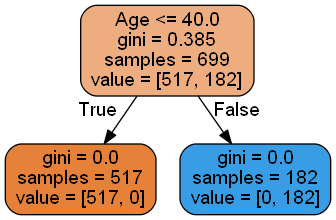

In [355]:
dot_data = StringIO()  
export_graphviz(dtree, out_file=dot_data,feature_names=features,filled=True,rounded=True)

graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png())  

In [356]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

In [385]:
X_train, X_test, y_train, y_test = train_test_split(store_orders[['Age','Bill_amount', '#_of_calls_in_the_past','used_app_before','Income','used_website_before']], store_orders['Called_within_1_day'], test_size=0.30, random_state=99)

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train);

In [381]:
rfc_pred = rfc.predict(X_test)
print(confusion_matrix(y_test,rfc_pred))

[[233   0]
 [  0  67]]


In [382]:
print(classification_report(y_test,rfc_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       233
          1       1.00      1.00      1.00        67

avg / total       1.00      1.00      1.00       300



In [386]:
vector_names = list(X_orig.columns)

rfc_ranks = zip(vector_names, rfc.feature_importances_)
set(rfc_ranks)

{('#_of_calls_in_the_past', 0.12456478988170837),
 ('Age', 0.59719568345866425),
 ('Bill_amount', 0.0047419770886270272),
 ('Income', 0.01384664130160731),
 ('used_app_before', 0.23325660814103993),
 ('used_website_before', 0.026394300128352925)}

Top 3 features: Age, used_app_before, and #_of_calls_in_the_past

Selected featuers the same as features selected using chi square test

### Call Sentiment - analyze those with sentiments recorded

In [361]:
store_orders_sentiment = store_orders[store_orders['Avg_Sentiment_past_Calls'].notnull()]
# Outlier in Bill_amount of 10,0000,0000 - remove it
store_orders_sentiment = store_orders_sentiment[store_orders_sentiment['Bill_amount'] < 1000000.000] 
store_orders_sentiment.groupby('Called_within_1_day').count()['Customer_ID']
#sns.boxplot(x='Called_within_1_day',y='Income',data=store_orders_sentiment,palette='winter', ax=ax[0,2])

Called_within_1_day
0    256
1    249
Name: Customer_ID, dtype: int64

In [408]:
store_orders_sentiment.groupby('Called_within_1_day').mean()

,Customer_ID,Age,Bill_amount,used_app_before,used_website_before,Income,#_of_calls_in_the_past,Avg_Sentiment_past_Calls
Called_within_1_day,,,,,,,,
0,0.508,22.551,10.711,0.910,0.910,305643.043,10.223,2.809
1,0.496,65.430,10.980,0.080,0.602,281267.016,10.667,-7.458


In [363]:
store_orders_sentiment_corr = store_orders_sentiment[['Called_within_1_day','Age','Bill_amount','Avg_Sentiment_past_Calls',
                                  '#_of_calls_in_the_past','used_app_before','Income','used_website_before']]
store_orders_sentiment_corr.corr()['Called_within_1_day']

Called_within_1_day         1.000
Age                         0.950
Bill_amount                 0.023
Avg_Sentiment_past_Calls   -0.606
#_of_calls_in_the_past      0.037
used_app_before            -0.830
Income                     -0.106
used_website_before        -0.359
Name: Called_within_1_day, dtype: float64

In [364]:
X_train, X_test, y_train, y_test = train_test_split(store_orders_sentiment[['Age','Bill_amount', '#_of_calls_in_the_past','used_app_before','Income','used_website_before','Avg_Sentiment_past_Calls']], store_orders_sentiment['Called_within_1_day'], test_size=0.30, random_state=99)

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train);

In [373]:
vector_names = list(X_train.columns)

rfc_ranks = zip(vector_names, rfc.feature_importances_)
set(rfc_ranks)

{('#_of_calls_in_the_past', 0.026468511839670646),
 ('Age', 0.49437261722808906),
 ('Avg_Sentiment_past_Calls', 0.14269107211986598),
 ('Bill_amount', 0.0053431699238410324),
 ('Income', 0.017106826392565021),
 ('used_app_before', 0.27994226476602635),
 ('used_website_before', 0.034075537729941943)}

Age and used_app_before seem to be the most important indicators, followed by Avg_Sentiment_past_Calls